In [42]:
import torch 
import torch.nn.functional as F
import math
import numpy as np
from matplotlib import pyplot as plt 

In [43]:

def quantize_adaptivfloat(float_arr, n_bits=8, n_exp=4, bias = None):
    
    n_mant = n_bits-1-n_exp
    # 1. store sign value and do the following part as unsigned value
    sign = torch.sign(float_arr)
    float_arr = torch.abs(float_arr)
    
    if (bias == None):
       bias_temp = torch.frexp(float_arr.max())[1]-1
       bias = (2**(n_exp-1) - 1) - bias_temp
        
    # 2. limits the range of output float point
    min_exp = -2**(n_exp-1)+2-bias 
    max_exp = 2**(n_exp-1)-1-bias 
    
    min_value = 2.**min_exp
    max_value = (2.**max_exp)*(2-2**(-n_mant))

    # Non denormal part 
    float_arr[float_arr < min_value] = 0
    
    ## 2.2. reduce too large values to max value of output format
    float_arr[float_arr > max_value] = max_value
    
    # 3. get mant, exp (the format is different from IEEE float)
    mant, exp = torch.frexp(float_arr)

    
    # 3.1 change mant, and exp format to IEEE float format
    # no effect for exponent of 0 outputs
    mant = 2*mant
    exp = exp-1
   
    power_exp = torch.exp2(exp)
    ## 4. quantize mantissa
    scale = 2**(-n_mant) ## e.g. 2 bit, scale = 0.25
    mant = ((mant/scale).round())*scale
    
    float_out = sign*power_exp*mant
    
    return float_out



def flint_value(self, n_bits=8,  exp_base = 0):
        ################## Flint Representation #################
        B = n_bits

        value_bit = B
        assert(value_bit >= 2)

        exp_num =     value_bit * 2 - 1
        neg_exp_num = value_bit - 1
        pos_exp_num = value_bit - 1
       
        
        exp_max = pos_exp_num + exp_base
        exp_min = -neg_exp_num

        ## zero
        values = [0.]

        # values = [0.]
        ## exponent negtive
        for i in range(0, neg_exp_num + 1):
            exp_bit = i + 2
            exp_value = -(exp_bit - 1)
            mant_bit = value_bit - exp_bit
            for j in range(int(2 ** mant_bit)):
                v = 2 ** exp_value * (1 + 2 ** (-mant_bit) * j)
                values.append(v)
                if self.is_signed:
                    values.append(-v)

        ## exponent zero
        exp_bit = 2
        exp_value = 0
        mant_bit = value_bit - exp_bit
        for j in range(int(2 ** mant_bit)):
            v = 2 ** (exp_value + exp_base) * (1 + 2 ** (-mant_bit) * j)
            values.append(v)

        ## exponent positive     
        for i in range(1, pos_exp_num):
            exp_bit = i + 2
            exp_value = i
            mant_bit = value_bit - exp_bit
            for j in range(int(2 ** mant_bit)):
                v = 2 ** (exp_value + exp_base) * (1 + 2 ** (-mant_bit) * j)
                values.append(v)

        ## max value
        values.append(2 ** exp_max)


        return values


def bit_flexible(float_arr, length = 10,n_bits=8,  exp_base = 0):
    
    reg = n_bits-1-exp_base #dynamic precision
    # store sign value and do the following part as unsigned value
    sign = torch.sign(float_arr)
    float_arr = torch.abs(float_arr)
     
    # limits the range of output 
    min_precision = 2**(-(reg-1))
    max_value = 2**reg

    # Non denormal part 
    float_arr[float_arr < min_precision] = 0
    float_arr[float_arr > max_value] = max_value
    # convert float to our flexible format
    integer = np.floor(float_arr)
    mant = float_arr - integer
    # print("int:",integer)
    # print("man:",mant)
    remain = reg - integer - 1
    fraction = 2 **(-remain)
    # print("fraction:", fraction)
    m = np.rint(mant/fraction) * fraction
    # print("m:", m)
    outs = []
    for i in range(0,length):
      if integer[i] > 1:
        #  base_exp = 2**(integer[i]-1) 
         base_exp = integer[i]
         v = sign[i]*(base_exp+m[i])
         outs.append(v)
    
      if integer[i] == 1:
         base_exp = 2**(integer[i]-1) 
         v = sign[i]*(base_exp*(1+m[i]))
         outs.append(v)
      
      if integer[i] == 0:
         base_exp = 1
         v = sign[i]*base_exp*(m[i])
         outs.append(v)
    
    outs = torch.Tensor(outs)

    return outs


In [44]:

def dynbit(n_bits, x: torch.Tensor):
        
        # n_bits = 4
        # print("before weight shape :",x.shape)
        ori_shape = x.shape
        x = x.reshape(-1)
        
#         length_tensor = x.size(0)
        length_tensor = x.size(0)
        exp_base = 0
        reg = n_bits-1-exp_base #dynamic precision
    # store sign value and do the following part as unsigned value
        sign = torch.sign(x)
        float_arr = torch.abs(x)
     
    # limits the range of output 
        min_precision = 2**(-(reg-1))
        max_value = 2**reg

    # Non denormal part 
        float_arr[float_arr < min_precision] = 0
        float_arr[float_arr > max_value] = max_value
    # convert float to our flexible format
        integer = torch.floor(float_arr)
        mant = float_arr - integer
    # print("int:",integer)
    # print("man:",mant)
        remain = reg - integer - 1
        fraction = 2 **(-remain)
    # print("fraction:", fraction)
        m = torch.round(mant/fraction) * fraction
    # print("m:", m)
        outs = []
        for i in range(0,length_tensor):
           if integer[i] > 1:
        #  base_exp = 2**(integer[i]-1) 
             base_exp = integer[i]
             v = sign[i]*(base_exp+m[i])
             outs.append(v)
    
           if integer[i] == 1:
             base_exp = 2**(integer[i]-1) 
             v = sign[i]*(base_exp*(1+m[i]))
             outs.append(v)
      
           if integer[i] == 0:
             base_exp = 1
             v = sign[i]*base_exp*(m[i])
             outs.append(v)
    
        x_out = torch.Tensor(outs)
        x_out = x_out.reshape(ori_shape)
        x_out = x_out.cuda()
        print("After shape :",x_out.shape)
        return x_out

In [45]:

class Bin2Dec():
    def __init__(self):
        pass

    def bin2dec(self, a):
        a_reverse = self.reverse(a)  # 取反
    
        a_add_1 = self.add_1(a_reverse)  # 二进制加1
        a_int = -int(a_add_1, 2)
        return a_int

    def bin2dec_auto(self, a):
        if a[0] == '1':  # 如果首位是1，复数转换
            a_output = int(a, 2)
        else:
            a_output = int(a, 2)
        return a_output

    def add_1(self, binary_inpute):  # 二进制编码加1
        _, out = bin(int(binary_inpute, 2) + 1).split("b")
        return out

    def reverse(self, binary_inpute):  # 取反操作
        binary_out = list(binary_inpute)
        for epoch, i in enumerate(binary_out):
            if i == "0":
                binary_out[epoch] = "1"
            else:
                binary_out[epoch] = "0"
        return "".join(binary_out)
    
def bit_essential(bin_str):
       essential_num = 0
       for b in range(len(bin_str)):
        if bin_str[b] == '1':
            essential_num += 1
       return essential_num

def lsb_quant(bin_str,bit_num,expect_eb=3):
        EB = bit_num
        quant_bit_num = EB - expect_eb
        quant_bit = list(bin_str)
        length = len(bin_str) - 1
        one_index = []
        for b in range(len(bin_str)):
          if bin_str[length-b] == '1':
            one_index.append(length-b)
           

        for b in range(quant_bit_num):
            quant_index = one_index[b]
            quant_bit[quant_index] = '0'

        quant_bit = ''.join(quant_bit)
        return quant_bit
    

def lsb_quant_0(value,bin_str,bit_num,expect_eb=3):
    EB = bit_num
    quant_bit_num = expect_eb - EB
    quant_bit = list(bin_str)

            
    if value < 0:
            length = len(bin_str) - 1
            one_index = []
            if length < expect_eb:
               for b in range(expect_eb-length):
                 quant_bit.append('1')
                 add_1 = expect_eb - length
            
               for b in range(len(quant_bit)):
                 if quant_bit[length-b] == '0':
                    one_index.append(length-b)
        
               for b in range(quant_bit_num-add_1):
                   quant_index = one_index[b]
                   quant_bit[quant_index] = '1'
            
            if length == expect_eb:
               for b in range(len(bin_str)):
                  if bin_str[b] == '0':
                     one_index.append(b)
           

               for b in range(quant_bit_num):
                  quant_index = one_index[b]
                  quant_bit[quant_index] = '1'
    
            if length > expect_eb:
                # print(bin_str)
                for b in range(len(bin_str)):
                  if bin_str[length-b] == '0':
                     one_index.append(length-b)


                for b in range(quant_bit_num):
                     quant_index = one_index[b]
                     
                     quant_bit[quant_index] = '1'  
                    #  print(quant_bit)
            
            
    if value >= 0:
            length = len(bin_str) 
            one_index = []
            if length < expect_eb:
               for b in range(expect_eb-length):
                 quant_bit.append('1')
                 add_1 = expect_eb - length
            
               for b in range(len(quant_bit)):
                 if quant_bit[length-b] == '0':
                    one_index.append(length-b)
        
               for b in range(quant_bit_num-add_1):
                   quant_index = one_index[b]
                   quant_bit[quant_index] = '1'
            
            if length == expect_eb:
               for b in range(len(bin_str)):
                  if bin_str[b] == '0':
                     one_index.append(b)
           

               for b in range(quant_bit_num):
                  quant_index = one_index[b]
                  quant_bit[quant_index] = '1'
    
            if length > expect_eb:

               for b in range(len(bin_str)):
                  if bin_str[length-b-1] == '0':
                     one_index.append(length-b-1)


               for b in range(quant_bit_num):
                     quant_index = one_index[b]
                     quant_bit[quant_index] = '1'
              
              
            #    print(quant_bit)
    quant_bit = ''.join(quant_bit)
    
    return quant_bit

def hamha_eb_value(i, q_type="int",expect_eb=3):
        bit_width = 8
        B = bit_width
#         if self.is_signed:
        B = bit_width - 1

        values = []
        values.append(0.)
        for i in range(1, i.size):
            bin_str = np.binary_repr(i)
            bit_num = bit_essential(bin_str)
           
#             print("EB",bit_num)
#             print("binary",bin_str)

            
            for s in range(expect_eb):
                        quant_value = wgt_arr[i]
#                         print("orignal value",quant_value)
                        bin_str = np.binary_repr(quant_value)
#                         print("binary",bin_str)
                        bit_num = bit_essential(bin_str)
#                         print("EB",bit_num)
                        quant_bit = lsb_quant_0(quant_value,bin_str,bit_num,expect_eb)
                        # print("quant bit", quant_bit)
                        quant_bit_num = bit_essential(quant_bit)
                        # print("Quant EB",quant_bit_num)
                        bin2dec = Bin2Dec()
                        a = bin2dec.bin2dec_auto(quant_bit)
#                         print(a)
                        wgt_arr[i] = a 
            
            
            bin_str = np.binary_repr(wgt_arr[i])
            bit_num = bit_essential(bin_str)
            for m in range(7-expect_eb):
                        quant_value = wgt_arr[i]
                        # print("orignal value",quant_value)
                        bin_str = np.binary_repr(quant_value)
                        # print("binary",bin_str)
                        bit_num = bit_essential(bin_str)
                        # print("EB",bit_num)
                        quant_bit = lsb_quant(bin_str,bit_num,expect_eb)
                        # print("quant bit", quant_bit)
                        quant_bit_num = bit_essential(quant_bit)
                        # print("Quant EB",quant_bit_num)
                        bin2dec = Bin2Dec()
                        a = bin2dec.bin2dec_auto(quant_bit)
                        wgt_arr[i] = a 
                        
            bin_str = np.binary_repr(wgt_arr[i])
            bit_num = bit_essential(bin_str)            
            if bit_num != expect_eb:
                          bin_str = np.binary_repr(wgt_arr[i])
                          new_bit_num = bit_essential(bin_str)
                          print("binary",i)
                          print("new EB",new_bit_num)
                          
            values.append(wgt_arr[i])
#         if self.is_signed:
            values.append(-wgt_arr[i])

#             if q_type == "int":
# #             if self.is_signed:
#                 values.append(-2 ** B)
        # print("int values :", values)

        return values

In [46]:
from bisect import bisect_left


def quantize_csd(input_num, eb=2):
    twoslist = [1, 2, 4, 8, 16, 32, 64, 128]
    iter_num = input_num
    quant_num = 0
    for index in range(eb):
        base = findclosest(twoslist, iter_num)
        if index == 0:
            quant_num = base
            # print("the 1st quant num is ", quant_num)
            if base > iter_num:
                sign_flag = 0  # 0-minus
            else:
                sign_flag = 1  # 1-plus
            # print("sign flag =", sign_flag)
        else:
            if sign_flag == 0:
                quant_num = quant_num - base
            else:
                quant_num = quant_num + base
            # print("the quant num is ", quant_num)
            if base > iter_num:
                if old_sign_flag == 0:
                    sign_flag = 1
                else:
                    sign_flag = 0
            else:
                if old_sign_flag == 0:
                    sign_flag = 0
                else:
                    sign_flag = 1
            # print("sign flag =", sign_flag)
        old_sign_flag = sign_flag
        iter_num = abs(base - iter_num)
        # print("new iternum =", iter_num)
    return quant_num


def findclosest(myList, input_num):
    if (input_num > myList[-1] or input_num < myList[0]):
        return False
    pos = bisect_left(myList, input_num)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - input_num < input_num - before:
        return after
    else:
        return before

# def quantize_csd(input_num, eb=2):
#     twoslist = [1, 2, 4, 8, 16, 32, 64, 128]
#     iter_num = input_num
#     quant_num = 0
#     for index in range(eb):
#         error_min_abs = 256
#         for twos in twoslist:
#             error = abs(twos - iter_num)
#             if error_min_abs == 256 or error_min_abs > error:
#                 error_min_abs = error
#                 base = twos
# #                 print("loop base = ", base)
#             else:
#                 if index == 0:
#                     quant_num = base
# #                     print("the 1st quant num is ", quant_num)
#                 else:
#                     if sign_flag == 0:
#                         quant_num = quant_num - base
#                     else:
#                         quant_num = quant_num + base
# #                     print("the 2nd quant num is ", quant_num)
#                 break
#         iter_num = abs(base - iter_num)
# #         print("new iternum =", iter_num)
#         old_base = base
#         if base > iter_num:
#             sign_flag = 0  # 0-minus
#         else:
#             sign_flag = 1  # 1-plus
#     return quant_num


def hamha_csd_value(i, q_type="int",expect_eb=3):
        bit_width = 8
        B = bit_width
#         if self.is_signed:
        B = bit_width - 1
#         wgt_arr = i

        values = []
        values.append(0.)
        for i in range(1, wgt_arr.size):
            bin_str = np.binary_repr(i)
            bit_num = bit_essential(bin_str)
           


            
            for s in range(expect_eb):
                        quant_value = wgt_arr[i]
#                         print("orignal value",quant_value)
                        quant_bit_num = quantize_csd(quant_value,expect_eb)
#                         print("binary",bin_str)
                    
#                         print(a)
                        wgt_arr[i] = quant_bit_num
            
        
                          
            values.append(wgt_arr[i])
#         if self.is_signed:
            values.append(-wgt_arr[i])

#             if q_type == "int":
# #             if self.is_signed:
#                 values.append(-2 ** B)
        # print("int values :", values)

        return values

In [47]:
# i = 16*torch.randn(3,224,224)
# i = np.random.uniform(-128,128,1000)
i = 100*torch.FloatTensor(3,224,224).normal_(0, 0.01)

#i = torch.FloatTensor(3,224,224).uniform_(-4, 4)

i = i.reshape(-1)
print(i)
out = quantize_adaptivfloat(i)
out1 = bit_flexible(i,length=3*224*224)

print(out)
   
print(out1)

tensor([ 1.2213,  0.3013,  0.6989,  ..., -0.8453,  1.1784, -0.2529])
tensor([ 1.2500,  0.3125,  0.6875,  ..., -0.8750,  1.1250, -0.2500])
tensor([ 1.2188,  0.2969,  0.7031,  ..., -0.8438,  1.1875, -0.2500])


In [48]:
# i = 16*torch.randn(3,224,224)

# i = 5*torch.FloatTensor(100).normal_(0, 0.2)
i = torch.linspace(-10,10,100)
#i = torch.FloatTensor(150).uniform_(-10, 10)

i = i.reshape(-1)


out1 = dynbit(5,i)
out = quantize_adaptivfloat(i)
# out1 = bit_flexible(i,length=100)
i = torch.sort(i).values
out1 = torch.sort(out1).values
print(i)
print(out1)


After shape : torch.Size([100])
tensor([-10.0000,  -9.7980,  -9.5960,  -9.3939,  -9.1919,  -8.9899,  -8.7879,
         -8.5859,  -8.3838,  -8.1818,  -7.9798,  -7.7778,  -7.5758,  -7.3737,
         -7.1717,  -6.9697,  -6.7677,  -6.5657,  -6.3636,  -6.1616,  -5.9596,
         -5.7576,  -5.5556,  -5.3535,  -5.1515,  -4.9495,  -4.7475,  -4.5455,
         -4.3434,  -4.1414,  -3.9394,  -3.7374,  -3.5354,  -3.3333,  -3.1313,
         -2.9293,  -2.7273,  -2.5253,  -2.3232,  -2.1212,  -1.9192,  -1.7172,
         -1.5152,  -1.3131,  -1.1111,  -0.9091,  -0.7071,  -0.5051,  -0.3030,
         -0.1010,   0.1010,   0.3030,   0.5051,   0.7071,   0.9091,   1.1111,
          1.3131,   1.5152,   1.7172,   1.9192,   2.1212,   2.3232,   2.5253,
          2.7273,   2.9293,   3.1313,   3.3333,   3.5354,   3.7374,   3.9394,
          4.1414,   4.3434,   4.5455,   4.7475,   4.9495,   5.1515,   5.3535,
          5.5556,   5.7576,   5.9596,   6.1616,   6.3636,   6.5657,   6.7677,
          6.9697,   7.1717,   7.

Text(0, 0.5, 'Normalized Frequency')

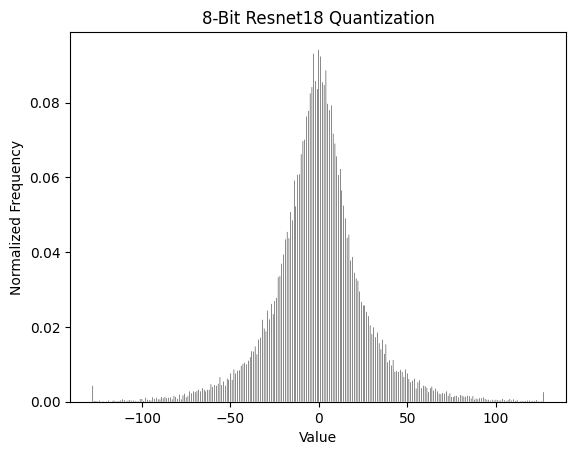

In [49]:
import numpy as np
from torchvision.models.quantization import resnet18,ResNet18_QuantizedWeights,mobilenet_v2, MobileNet_V2_QuantizedWeights,resnet18, resnet50, ResNet18_QuantizedWeights, ResNet50_QuantizedWeights
from eb_anal import layer_wise_bit_level, kernel_wise_bit_level
import matplotlib.pyplot as plt

# For resnet 18
weights = ResNet18_QuantizedWeights.DEFAULT
model = resnet18(weights=weights, quantize=True)

# For resnet 50
# weights = MobileNet_V2_QuantizedWeights.DEFAULT
# model = mobilenet_v2(weights=weights, quantize=True)
model.eval()
# print(model)
# Select different layers here
# Names can be get in wgt_test_quant.ipynb
resnet18_weight1 = model.layer1[0].conv2.weight().flatten().int_repr().cpu().detach().numpy()
wgt_arr = model.layer1[0].conv2.weight().flatten().int_repr().cpu().detach().numpy()
# wgt_arr = model.features[0].conv2.weight().int_repr().cpu().detach().numpy()

# plot
plt.hist(resnet18_weight1, bins=1000, density=True, alpha=1,
         histtype='stepfilled',  facecolor = 'black',  linewidth=1)
# y = norm.pdf(bins,dymobilenet_v2_feature1_mean,dymobilenet_v2_feature1_sigma)
# plt.plot(bins,y,'r--')


plt.title("8-Bit Resnet18 Quantization")
plt.xlabel('Value')
plt.ylabel('Normalized Frequency')

In [50]:
print(resnet18_weight1.size)
print(resnet18_weight1[0])

36864
10


In [12]:
resnet18_weight1_hamha_eb2_out1 = hamha_eb_value(resnet18_weight1,expect_eb=2)
print(resnet18_weight1_hamha_eb2_out1)

[0.0, -40, 40, -3, 3, -33, 33, 96, -96, -40, 40, -20, 20, -72, 72, -20, 20, -6, 6, 9, -9, -3, 3, -3, 3, 17, -17, -5, 5, -20, 20, 3, -3, 3, -3, -3, 3, 9, -9, 5, -5, 5, -5, -3, 3, 5, -5, 5, -5, 5, -5, 3, -3, 12, -12, -24, 24, -20, 20, 5, -5, -48, 48, -24, 24, -3, 3, -36, 36, -18, 18, 6, -6, -3, 3, -3, 3, 5, -5, 6, -6, -3, 3, 3, -3, 9, -9, 3, -3, 24, -24, 24, -24, 24, -24, 24, -24, 24, -24, 36, -36, 24, -24, 24, -24, 33, -33, 6, -6, 9, -9, 6, -6, 12, -12, -12, 12, -5, 5, -5, 5, -5, 5, -3, 3, -5, 5, 6, -6, -6, 6, -10, 10, -5, 5, -12, 12, 9, -9, 6, -6, -3, 3, 12, -12, 18, -18, 24, -24, 9, -9, 20, -20, 20, -20, 24, -24, 20, -20, 12, -12, 17, -17, 20, -20, 12, -12, 10, -10, 10, -10, 9, -9, 12, -12, 20, -20, 18, -18, 5, -5, 9, -9, 3, -3, -3, 3, 20, -20, 12, -12, 3, -3, -3, 3, 6, -6, 12, -12, 17, -17, 18, -18, -6, 6, -3, 3, 10, -10, 10, -10, 17, -17, 18, -18, -20, 20, -10, 10, -10, 10, -5, 5, 10, -10, 10, -10, -10, 10, -36, 36, -10, 10, -12, 12, -6, 6, 3, -3, -9, 9, -12, 12, 10, -10, 3, -3, 3, 

Text(0, 0.5, 'Normalized Frequency')

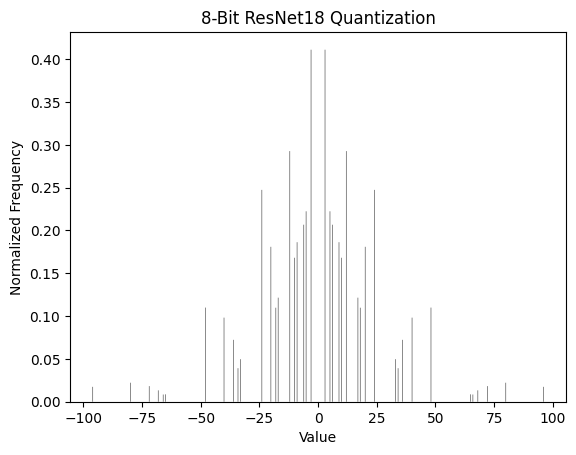

In [12]:
# plot
plt.hist(resnet18_weight1_hamha_eb2_out1, bins=1000, density=True, alpha=1,
         histtype='stepfilled',  facecolor = 'black',  linewidth=1)
# y = norm.pdf(bins,dymobilenet_v2_feature1_mean,dymobilenet_v2_feature1_sigma)
# plt.plot(bins,y,'r--')


plt.title("8-Bit ResNet18 Quantization")
plt.xlabel('Value')
plt.ylabel('Normalized Frequency')

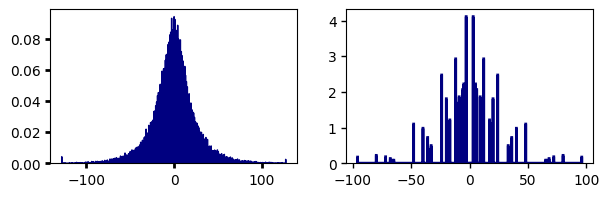

In [14]:


fig, subfig = plt.subplots(1,2,figsize=(7,2))
subfig[1].hist(resnet18_weight1_hamha_eb2_out1, bins=10000, density=True, alpha=1,
          histtype='stepfilled', facecolor = 'navy', edgecolor='navy', linewidth=2)


# subfig[1].set_ylim(0,2)
# subfig[1].set_xlim(-2,2)
# mobilenet_v2_feature1_max = max(resnet18_weight1_hamha_eb2_out1)
# print(mobilenet_v2_feature1_max)
# mobilenet_v2_feature1_min = min(resnet18_weight1_hamha_eb2_out1)
# print(mobilenet_v2_feature1_min)

subfig[1].tick_params(axis='both',labelsize=10,width=1,labelcolor="black")




subfig[0].hist(resnet18_weight1, bins=1000, density=True, alpha=1,
         histtype='step', facecolor = 'navy', edgecolor='navy', linewidth=1)

# subfig[0].set_xlim(-2,2)


subfig[0].tick_params(axis='both',labelsize=10,width=2,labelcolor="black")

plt.savefig('Resnet18_weight_lsb_eb2.svg',dpi=1200,format='svg')

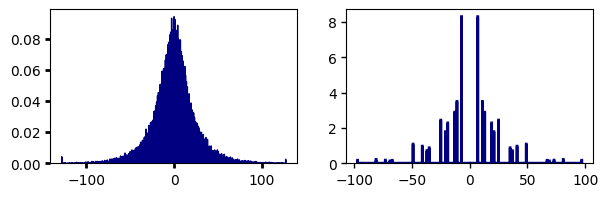

In [15]:
resnet18_weight1_hamha_eb3_out1 = hamha_eb_value(resnet18_weight1,expect_eb=3)

fig, subfig = plt.subplots(1,2,figsize=(7,2))
subfig[1].hist(resnet18_weight1_hamha_eb3_out1, bins=10000, density=True, alpha=1,
          histtype='stepfilled', facecolor = 'navy', edgecolor='navy', linewidth=2)


# subfig[1].set_ylim(0,2)
# subfig[1].set_xlim(-2,2)
# mobilenet_v2_feature1_max = max(resnet18_weight1_hamha_eb2_out1)
# print(mobilenet_v2_feature1_max)
# mobilenet_v2_feature1_min = min(resnet18_weight1_hamha_eb2_out1)
# print(mobilenet_v2_feature1_min)

subfig[1].tick_params(axis='both',labelsize=10,width=1,labelcolor="black")




subfig[0].hist(resnet18_weight1, bins=1000, density=True, alpha=1,
         histtype='step', facecolor = 'navy', edgecolor='navy', linewidth=1)

# subfig[0].set_xlim(-2,2)


subfig[0].tick_params(axis='both',labelsize=10,width=2,labelcolor="black")

plt.savefig('Resnet18_weight_lsb_eb3.svg',dpi=1200,format='svg')

97
-97


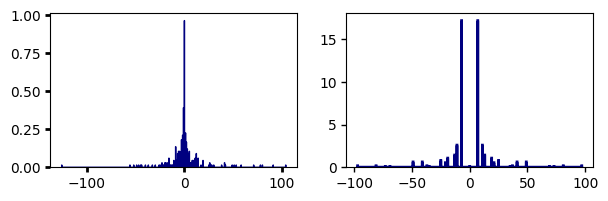

In [16]:
mobilenet_weight1_hamha_eb3_out1 = hamha_eb_value(mobilenet_weight1,expect_eb=3)
fig, subfig = plt.subplots(1,2,figsize=(7,2))
subfig[1].hist(mobilenet_weight1_hamha_eb3_out1, bins=10000, density=True, alpha=1,
          histtype='stepfilled', facecolor = 'navy', edgecolor='navy', linewidth=2)


# subfig[1].set_ylim(0,2)
# subfig[1].set_xlim(-2,2)
mobilenet_v2_feature1_max = max(mobilenet_weight1_hamha_eb3_out1)
print(mobilenet_v2_feature1_max)
mobilenet_v2_feature1_min = min(mobilenet_weight1_hamha_eb3_out1)
print(mobilenet_v2_feature1_min)

subfig[1].tick_params(axis='both',labelsize=10,width=1,labelcolor="black")




subfig[0].hist(mobilenet_weight1, bins=1000, density=True, alpha=1,
         histtype='step', facecolor = 'navy', edgecolor='navy', linewidth=1)

# subfig[0].set_xlim(-2,2)


subfig[0].tick_params(axis='both',labelsize=10,width=2,labelcolor="black")

plt.savefig('Mobilenet_v2_weight_lsb_eb3.svg',dpi=1200,format='svg')

In [23]:
print(quantize_csd(75,2))

72


In [24]:
print(hamha_csd_value(mobilenet_weight1, 2))

[0.0, 2, -2, 2, -2, 2, -2, 1, -1, 8, -8, 2, -2, 2, -2, 1, -1, 1, -1, 2, -2, 1, -1, 1, -1, 4, -4, 30, -30, 1, -1, 1, -1, 31, -31, 1, -1, 2, -2, 8, -8, 1, -1, 1, -1, 15, -15, 2, -2, 4, -4, 2, -2, 4, -4, 2, -2, 2, -2, 2, -2, 31, -31, 1, -1, 2, -2, 2, -2, 8, -8, 15, -15, 5, -5, 2, -2, 2, -2, 1, -1, 4, -4, 15, -15, 15, -15, 15, -15, 2, -2, 4, -4, 8, -8, 1, -1, 2, -2, 57, -57, 1, -1, 30, -30, 8, -8, 1, -1, 2, -2, 1, -1, 1, -1, 1, -1, 15, -15, 2, -2, 4, -4, 62, -62, 1, -1, 4, -4, 15, -15, 15, -15, 8, -8, 14, -14, 1, -1, 4, -4, 1, -1, 2, -2, 2, -2, 4, -4, 1, -1, 15, -15, 8, -8, 1, -1, 1, -1, 2, -2, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 4, -4, 1, -1, 15, -15, 8, -8, 1, -1, 15, -15, 15, -15, 1, -1, 15, -15, 2, -2, 6, -6, 30, -30, 2, -2, 2, -2, 4, -4, 1, -1, 7, -7, 31, -31, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 2, -2, 2, -2, 31, -31, 1, -1, 1, -1, 16, -16, 2, -2, 2, -2, 16, -16, 16, -16, 16, -16, 23, -23, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 

126
-126


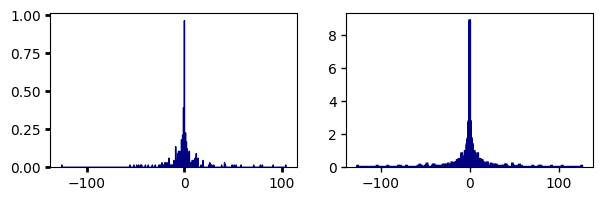

In [19]:
wgt_arr = model.features[1].conv[0][0].weight().flatten().int_repr().cpu().detach().numpy()
mobilenet_weight1_hamha_csd_eb3_out1 = hamha_csd_value(mobilenet_weight1,expect_eb=3)
fig, subfig = plt.subplots(1,2,figsize=(7,2))
subfig[1].hist(mobilenet_weight1_hamha_csd_eb3_out1, bins=10000, density=True, alpha=1,
          histtype='stepfilled', facecolor = 'navy', edgecolor='navy', linewidth=2)


# subfig[1].set_ylim(0,2)
# subfig[1].set_xlim(-2,2)
mobilenet_v2_feature1_max = max(mobilenet_weight1_hamha_csd_eb3_out1)
print(mobilenet_v2_feature1_max)
mobilenet_v2_feature1_min = min(mobilenet_weight1_hamha_csd_eb3_out1)
print(mobilenet_v2_feature1_min)

subfig[1].tick_params(axis='both',labelsize=10,width=1,labelcolor="black")




subfig[0].hist(mobilenet_weight1, bins=1000, density=True, alpha=1,
         histtype='step', facecolor = 'navy', edgecolor='navy', linewidth=1)

# subfig[0].set_xlim(-2,2)


subfig[0].tick_params(axis='both',labelsize=10,width=2,labelcolor="black")

plt.savefig('Mobilenet_v2_weight_csd_eb3.svg',dpi=1200,format='svg')

/tmp/ipykernel_1970180/3764424408.py:36: RuntimeWarning: overflow encountered in byte_scalars
  iter_num = abs(base - iter_num)


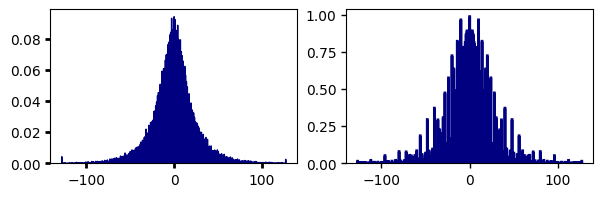

In [18]:
wgt_arr = model.layer1[0].conv2.weight().flatten().int_repr().cpu().detach().numpy()
resnet18_weight1_hamha_csd_eb3_out1 = hamha_csd_value(resnet18_weight1,expect_eb=3)
fig, subfig = plt.subplots(1,2,figsize=(7,2))
subfig[1].hist(resnet18_weight1_hamha_csd_eb3_out1, bins=10000, density=True, alpha=1,
          histtype='stepfilled', facecolor = 'navy', edgecolor='navy', linewidth=2)


# subfig[1].set_ylim(0,2)


subfig[1].tick_params(axis='both',labelsize=10,width=1,labelcolor="black")




subfig[0].hist(resnet18_weight1, bins=1000, density=True, alpha=1,
         histtype='step', facecolor = 'navy', edgecolor='navy', linewidth=1)

# subfig[0].set_xlim(-2,2)


subfig[0].tick_params(axis='both',labelsize=10,width=2,labelcolor="black")

plt.savefig('resnet18_weight_csd_eb3.svg',dpi=1200,format='svg')

In [18]:
wgt_arr = model.features[1].conv[0][0].weight().flatten().int_repr().cpu().detach().numpy()
mobilenet_weight1_hamha_csd_eb3_out1 = hamha_csd_value(mobilenet_weight1,expect_eb=2)
fig, subfig = plt.subplots(1,2,figsize=(7,2))
subfig[1].hist(mobilenet_weight1_hamha_csd_eb3_out1, bins=10000, density=True, alpha=1,
          histtype='stepfilled', facecolor = 'navy', edgecolor='navy', linewidth=2)


# subfig[1].set_ylim(0,2)
# subfig[1].set_xlim(-2,2)
mobilenet_v2_feature1_max = max(mobilenet_weight1_hamha_csd_eb3_out1)
print(mobilenet_v2_feature1_max)
mobilenet_v2_feature1_min = min(mobilenet_weight1_hamha_csd_eb3_out1)
print(mobilenet_v2_feature1_min)

subfig[1].tick_params(axis='both',labelsize=10,width=1,labelcolor="black")




subfig[0].hist(mobilenet_weight1, bins=1000, density=True, alpha=1,
         histtype='step', facecolor = 'navy', edgecolor='navy', linewidth=1)

# subfig[0].set_xlim(-2,2)


subfig[0].tick_params(axis='both',labelsize=10,width=2,labelcolor="black")

plt.savefig('Mobilenet_v2_weight_csd_eb2.svg',dpi=1200,format='svg')

AttributeError: 'QuantizableResNet' object has no attribute 'features'

In [58]:
from bisect import bisect_left


def quantize_csd(input_num, eb=2):
    twoslist = [1, 2, 4, 8, 16, 32, 64, 128]
    iter_num = input_num
    quant_num = 0
    for index in range(eb):
        base = findclosest(twoslist, iter_num)
        if index == 0:
            quant_num = base
            # print("the 1st quant num is ", quant_num)
            if base > iter_num:
                sign_flag = 0  # 0-minus
            else:
                sign_flag = 1  # 1-plus
            # print("sign flag =", sign_flag)
        else:
            if sign_flag == 0:
                quant_num = quant_num - base
            else:
                quant_num = quant_num + base
            # print("the quant num is ", quant_num)
            if base > iter_num:
                if old_sign_flag == 0:
                    sign_flag = 1
                else:
                    sign_flag = 0
            else:
                if old_sign_flag == 0:
                    sign_flag = 0
                else:
                    sign_flag = 1
            # print("sign flag =", sign_flag)
        old_sign_flag = sign_flag
        iter_num = abs(base - iter_num)
        # print("new iternum =", iter_num)
    return quant_num


def findclosest(myList, input_num):
    if (input_num > myList[-1] or input_num < myList[0]):
        return False
    pos = bisect_left(myList, input_num)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - input_num < input_num - before:
        return after
    else:
        return before

# def quantize_csd(input_num, eb=2):
#     twoslist = [1, 2, 4, 8, 16, 32, 64, 128]
#     iter_num = input_num
#     quant_num = 0
#     for index in range(eb):
#         error_min_abs = 256
#         for twos in twoslist:
#             error = abs(twos - iter_num)
#             if error_min_abs == 256 or error_min_abs > error:
#                 error_min_abs = error
#                 base = twos
# #                 print("loop base = ", base)
#             else:
#                 if index == 0:
#                     quant_num = base
# #                     print("the 1st quant num is ", quant_num)
#                 else:
#                     if sign_flag == 0:
#                         quant_num = quant_num - base
#                     else:
#                         quant_num = quant_num + base
# #                     print("the 2nd quant num is ", quant_num)
#                 break
#         iter_num = abs(base - iter_num)
# #         print("new iternum =", iter_num)
#         old_base = base
#         if base > iter_num:
#             sign_flag = 0  # 0-minus
#         else:
#             sign_flag = 1  # 1-plus
#     return quant_num


def hamha_csd_value(self, q_type="int",expect_eb=3):


           
        bit_width = 8
        B = bit_width
    
        B = bit_width - 1

        values = []
        ori=[]
        ori.append(0.)
        values.append(0.)
        for i in range(1, 2 ** B):
            bin_str = np.binary_repr(i)
            bit_num = bit_essential(bin_str)
#             ori.append(i) 
            ori.append(i) 

            for s in range(expect_eb):
                        quant_value = i
                        # print("orignal value",quant_value)
                        quant_bit_num = quantize_csd(quant_value,expect_eb)
                        # print("csd quant",quant_bit_num)
                        i = quant_bit_num
            
                        #   print("binary",i)
                        #   print("new EB",new_bit_num)
                         
#             values.append(i)
    
            values.append(i)


#                 values.append(-2 ** B)
        # values = torch.sort(values)
        # print("int csd values :", values)

        return values,ori



In [59]:

def int_value(self, q_type="int",expect_eb=7):
        bit_width = 8
        B = bit_width
     
        B = bit_width - 1

        values = []
        values.append(0.)
        ori=[]
        ori.append(0.)
        for i in range(1, 2 ** B):
            bin_str = np.binary_repr(i)
            bit_num = bit_essential(bin_str)
            # print("EB",bit_num)
            # print("binary",bin_str)
            # expect_eb = int(self.eb)
            ori.append(i) 
            
            for s in range(expect_eb):
                        quant_value = i
                        # print("orignal value",quant_value)
                        bin_str = np.binary_repr(quant_value)
                        # print("binary",bin_str)
                        bit_num = bit_essential(bin_str)
                        # print("EB",bit_num)
                        quant_bit = lsb_quant_0(i,bin_str,bit_num,expect_eb)
                        # print("quant bit", quant_bit)
                        quant_bit_num = bit_essential(quant_bit)
                        # print("Quant EB",quant_bit_num)
                        bin2dec = Bin2Dec()
                        a = bin2dec.bin2dec_auto(quant_bit)
                        i = a 
            
            
            bin_str = np.binary_repr(i)
            bit_num = bit_essential(bin_str)
            for m in range(7-expect_eb):
                        quant_value = i
                        # print("orignal value",quant_value)
                        bin_str = np.binary_repr(quant_value)
                        # print("binary",bin_str)
                        bit_num = bit_essential(bin_str)
                        # print("EB",bit_num)
                        quant_bit = lsb_quant(bin_str,bit_num,expect_eb)
                        # print("quant bit", quant_bit)
                        quant_bit_num = bit_essential(quant_bit)
                        # print("Quant EB",quant_bit_num)
                        bin2dec = Bin2Dec()
                        a = bin2dec.bin2dec_auto(quant_bit)
                        i = a 
                        
            bin_str = np.binary_repr(i)
            bit_num = bit_essential(bin_str)            

                          
            values.append(i)
      



        return values,ori

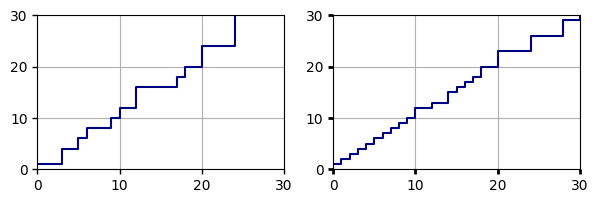

In [61]:
i = torch.IntTensor(1, 10)

i = i.reshape(-1)


lsb_out1,lsb_out2= int_value(i,expect_eb=2)
csd_out1,csd_out2 = hamha_csd_value(i,expect_eb=2)
# csd_out1 = torch.Tensor(csd_out1)
# csd_out1 = torch.sort(csd_out1)
# csd_out2 = torch.Tensor(csd_out2)
# csd_out2 = torch.sort(csd_out2)
# incsd_out1 = torch.Tensor(csd_out1)1 = in1.to("cpu")

# csd_out1 = csd_out1.to("cpu")
# csd_out2 = csd_out2.to("cpu")
# print(out2)
# plt.step(out1,out2,c='navy',linewidth=2)
# plt.tick_params(axis='both',labelsize=17,width=2,labelcolor="black")

# plt.savefig('LSB_hamha_Quant_eb2.svg',dpi=1200,format='svg')
# plt.show()


fig, subfig = plt.subplots(1,2,figsize=(7,2))
subfig[0].step(lsb_out1,lsb_out2,c='navy',linewidth=1.5)
# subfig[0].plot(lsb_out2,lsb_out2,c='red',linewidth=0.7)

subfig[0].set_ylim(0,30)
subfig[0].set_xlim(0,30)
subfig[0].grid()

subfig[0].tick_params(axis='both',labelsize=10,width=1,labelcolor="black")




subfig[1].step(csd_out1,csd_out2,c='navy',linewidth=1.5)
# subfig[1].plot(csd_out1,csd_out2,c='red',linewidth=0.7)
subfig[1].set_ylim(0,30)
subfig[1].set_xlim(0,30)
subfig[1].grid()



subfig[1].tick_params(axis='both',labelsize=10,width=2,labelcolor="black")

plt.savefig('lsb_csd_hamha_eb2.svg',dpi=1200,format='svg')

[0.0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 12, 14, 14, 15, 16, 17, 18, 18, 20, 20, 20, 24, 24, 24, 28, 28, 28, 30, 30, 31, 32, 33, 34, 34, 36, 36, 36, 40, 40, 40, 40, 40, 40, 48, 48, 48, 48, 48, 48, 48, 56, 56, 56, 56, 56, 56, 60, 60, 60, 62, 62, 63, 64, 65, 66, 66, 68, 68, 68, 72, 72, 72, 72, 72, 72, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 120, 120, 120, 120, 120, 120, 124, 124, 124, 126, 126, 127]
[0.0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115

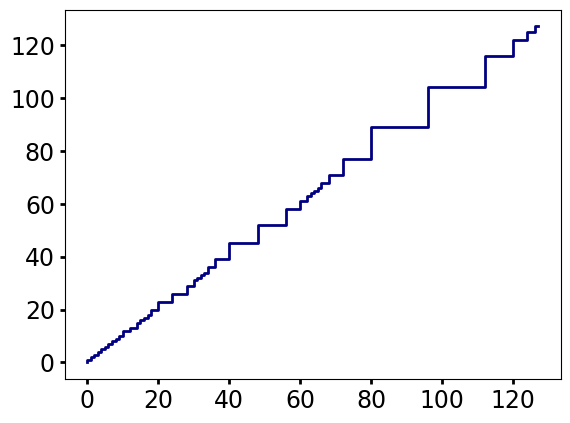

In [96]:
# wgt_arr = model.layer1[0].conv2.weight().flatten().int_repr().cpu().detach().numpy()
# i = torch.randint(3, 5, (3,))
i = torch.IntTensor(1, 10)

i = i.reshape(-1)


out1,out2 = hamha_csd_value(i,expect_eb=2)
in1 = in1.to("cpu")

# out1 = out1.to("cpu")
print(out1)
print(out2)

# # plt.ylim(0,1)
# # plt.xlim(0,1)

plt.step(out1,out2,c='navy',linewidth=2)
plt.tick_params(axis='both',labelsize=17,width=2,labelcolor="black")

plt.savefig('CSD_hamha_Quant_eb2.svg',dpi=1200,format='svg')
plt.show()

After shape : torch.Size([100])


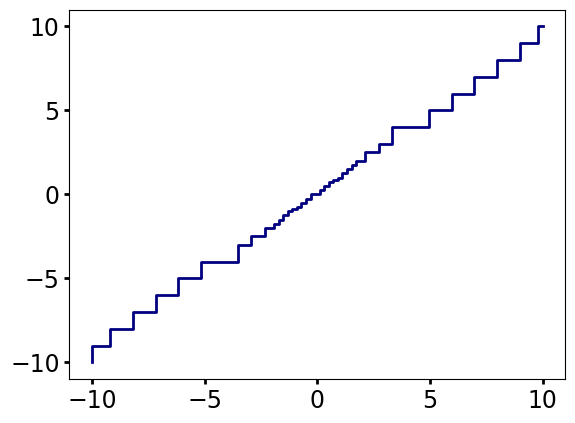

In [57]:
out1 = dynbit(5,i)
i = i.to("cpu")

out1 = out1.to("cpu")
# print(i)
# print(out1)
# plt.ylim(0,1)
# plt.xlim(0,1)

plt.step(i,out1,c='navy',linewidth=2)
plt.tick_params(axis='both',labelsize=17,width=2,labelcolor="black")

plt.savefig('4_bit_Dybit_Quant.svg',dpi=1200,format='svg')
plt.show()

tensor([-1.0000, -0.9798, -0.9596, -0.9394, -0.9192, -0.8990, -0.8788, -0.8586,
        -0.8384, -0.8182, -0.7980, -0.7778, -0.7576, -0.7374, -0.7172, -0.6970,
        -0.6768, -0.6566, -0.6364, -0.6162, -0.5960, -0.5758, -0.5556, -0.5354,
        -0.5152, -0.4949, -0.4747, -0.4545, -0.4343, -0.4141, -0.3939, -0.3737,
        -0.3535, -0.3333, -0.3131, -0.2929, -0.2727, -0.2525, -0.2323, -0.2121,
        -0.1919, -0.1717, -0.1515, -0.1313, -0.1111, -0.0909, -0.0707, -0.0505,
        -0.0303, -0.0101,  0.0101,  0.0303,  0.0505,  0.0707,  0.0909,  0.1111,
         0.1313,  0.1515,  0.1717,  0.1919,  0.2121,  0.2323,  0.2525,  0.2727,
         0.2929,  0.3131,  0.3333,  0.3535,  0.3737,  0.3939,  0.4141,  0.4343,
         0.4545,  0.4747,  0.4949,  0.5152,  0.5354,  0.5556,  0.5758,  0.5960,
         0.6162,  0.6364,  0.6566,  0.6768,  0.6970,  0.7172,  0.7374,  0.7576,
         0.7778,  0.7980,  0.8182,  0.8384,  0.8586,  0.8788,  0.8990,  0.9192,
         0.9394,  0.9596,  0.9798,  1.00

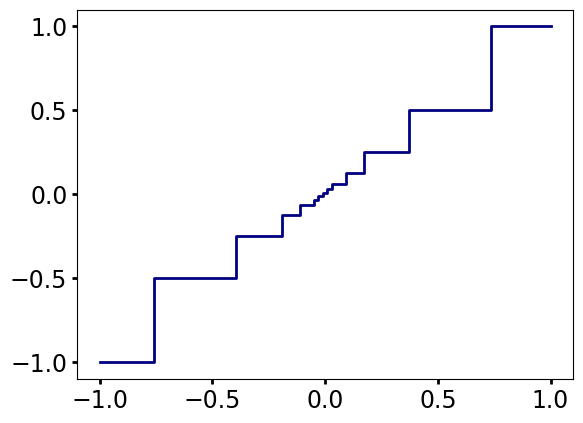

In [8]:

#i = torch.FloatTensor(150).uniform_(-10, 10)
print(i)
out = quantize_adaptivfloat(i,n_bits=5)
i = i.reshape(-1)
i = i.to("cpu")
out = out.to("cpu")
# print(i)
print(out)
# plt.ylim(0,1)
# plt.xlim(0,1)

plt.step(i,out,c='navy',linewidth=2)
plt.tick_params(axis='both',labelsize=17,width=2,labelcolor="black")


plt.show()

Text(0.5, 1.0, 'The distribution of random float ')

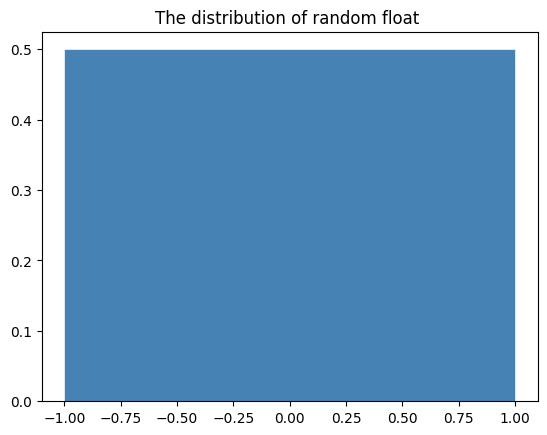

In [9]:
plt.hist(i, bins=100, density=True, alpha=1,
          histtype='stepfilled', facecolor = 'steelblue', edgecolor='ghostwhite', linewidth=0.5)
plt.title("The distribution of random float ")

In [11]:
# dybit_i = torch.from_numpy(i).float().to("cuda")
dybit_i = dynbit(8,i)

After shape : torch.Size([150])


Text(0, 0.5, 'Normalized Frequency')

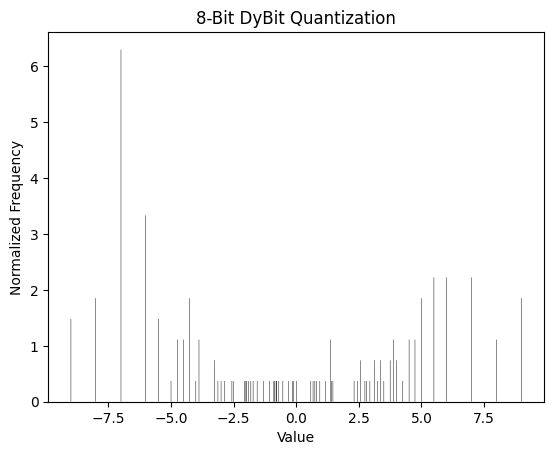

In [12]:
dybit_i = dybit_i.to("cpu")
n, bins, patches = plt.hist(dybit_i, bins=1000, density=True, alpha=1,
         histtype='stepfilled',  facecolor = 'black',  linewidth=0.5)
# y = norm.pdf(bins,dymobilenet_v2_feature1_mean,dymobilenet_v2_feature1_sigma)
# plt.plot(bins,y,'r--')


plt.title("8-Bit DyBit Quantization")
plt.xlabel('Value')
plt.ylabel('Normalized Frequency')

Text(0.5, 1.0, 'The distribution of bit flexible type')

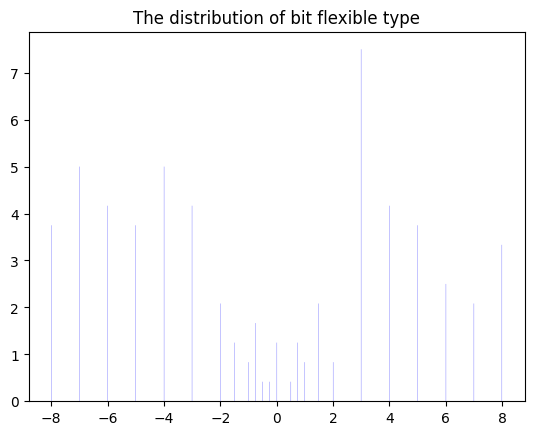

In [13]:
plt.hist(out1, bins=1000, density=True, alpha=0.5,
         histtype='stepfilled', color='blue',
         edgecolor='none');
plt.title("The distribution of bit flexible type")

Text(0.5, 1.0, 'The difference between float and bit flexible type')

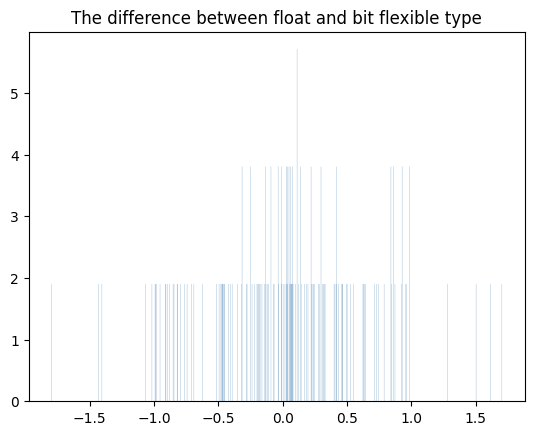

In [14]:
diff = out1 - i
plt.hist(diff, bins=1000, density=True, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none');
plt.title("The difference between float and bit flexible type")

In [8]:
#Mobilenet_V2
mobilenet_v2_feature1=np.load('/home/thomas/Unified_Quantization/ant_quantization/ImageNet/log/mobilnetv2_layer1.npy')
mobilenet_v2_feature10=np.load('/home/thomas/Unified_Quantization/ant_quantization/ImageNet/log/mobilnetv2_layer10.npy')
mobilenet_v2_feature18=np.load('/home/thomas/Unified_Quantization/ant_quantization/ImageNet/log/mobilnetv2_layer18.npy')

#ResNet18
resnet18_actlayer1=np.load('/home/thomas/Unified_Quantization/ant_quantization/ImageNet/log/resnet18_layer1.npy')

#VIT-BASE
vit_base16_enlayer1=np.load('/home/thomas/Unified_Quantization/ant_quantization/ImageNet/log/vit_Base16_layer1.npy')
vit_base16_enlayer1 = vit_base16_enlayer1.reshape(-1)
vit_base16_enlayer6_ln=np.load('/home/thomas/Unified_Quantization/ant_quantization/ImageNet/log/vit_Base_lnlayer6.npy')

#VIT-LARGE

#VIT-BASE
vit_large16_enlayer6=np.load('/home/thomas/Unified_Quantization/ant_quantization/ImageNet/log/ViT-Large16_layer6.npy')

In [9]:
import matplotlib.mlab as mlab
from scipy.stats import norm

In [10]:
print(mobilenet_v2_feature10)

[-0.09938336 -0.13372777 -0.09737094 ...  0.00226529  0.27073035
 -0.09505049]


In [11]:
resnet18_actlayer1_max = max(resnet18_actlayer1)
print(resnet18_actlayer1_max)
resnet18_actlayer1_min = min(resnet18_actlayer1)
print(resnet18_actlayer1_min)

17.293652
-19.878813


In [12]:
mobilenet_v2_feature18_max = max(mobilenet_v2_feature18)
print(mobilenet_v2_feature18_max)
mobilenet_v2_feature18_min = min(mobilenet_v2_feature18)
print(mobilenet_v2_feature18_min)

0.8024243
-0.7117829


17.293652
-19.878813
(12845056,)


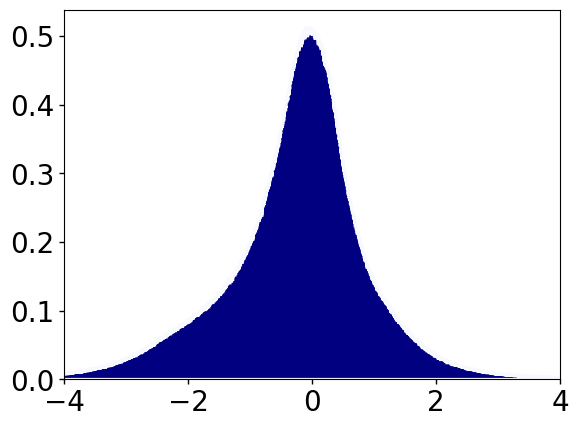

In [17]:
mobilenet_v2_feature10_mean = np.mean(mobilenet_v2_feature10)
mobilenet_v2_feature10_sigma = np.std(mobilenet_v2_feature10)
# n, bins, patches = plt.hist(mobilenet_v2_feature10, range=(-2,2), bins=1000, density=True, alpha=0.5,
#          histtype='stepfilled', color='blue',
#          edgecolor='none',label='mobilenet_v2')
# plt.hist(mobilenet_v2_feature10, range=(-2,2), bins=1000, density=True, alpha=0.7,
#          histtype='stepfilled', color='blue',
#          edgecolor='none',label='mobilenet_v2');

# mobilenet_v2_feature18_mean = np.mean(mobilenet_v2_feature18)
# mobilenet_v2_feature18_sigma = np.std(mobilenet_v2_feature18)
# n, bins, patches = plt.hist(mobilenet_v2_feature18, range=(-2,2), bins=1000, density=True, alpha=0.5,
#          histtype='stepfilled', color='blue',
#          edgecolor='none',label='mobilenet_v2')
# plt.hist(mobilenet_v2_feature18, range=(-2,2), bins=1000, density=True, alpha=0.5,
#          histtype='stepfilled', color='yellow',
#          edgecolor='none');

resnet18_actlayer1_mean = np.mean(resnet18_actlayer1)
resnet18_actlayer1_sigma = np.std(resnet18_actlayer1)
n, bins, patches = plt.hist(resnet18_actlayer1,  bins=10000, density=True, alpha=1,
          histtype='stepfilled', facecolor = 'navy', edgecolor='ghostwhite', linewidth=2)
# plt.hist(resnet18_actlayer1, bins=1000, density=True, alpha=0.5,
#          histtype='stepfilled', color='yellow',
#          edgecolor='none');
# plt.hist(mobilenet_v2_feature1, range=(-2,2), bins=1000, density=True, alpha=0.5,
#          histtype='stepfilled', color='gold',
#          edgecolor='none');
# plt.hist(resnet18_actlayer1, bins=1000,range=(-5,5),  density=True, alpha=0.5,
#          histtype='stepfilled', color='black',
#          edgecolor='none');
# plt.hist([resnet18_layer1,mobilenet_v2_feature10],bins=1000,range=(-5,5),  density=True, alpha=0.5,
#          histtype='stepfilled', 
#          edgecolor='none');
# plt.hist(resnet18_layer1, bins=1000, density=True, alpha=0.5,
#          histtype='stepfilled', color='yellow',
#          edgecolor='none');
# y = norm.pdf(bins,resnet18_actlayer1_mean,resnet18_actlayer1_sigma)
# plt.plot(bins,y,'r--')
# label=['MobileNet_V2 Feature10','MobileNet_V2 Feature18','MobileNet_V2 Feature1','ResNet']
# plt.legend(label)
# plt.title("CNN Activation Tensor Distribution")
# plt.xlabel('Value')
# plt.ylabel('Normalized Frequency')

plt.xlim(-4,4)
resnet18_actlayer1_max = max(resnet18_actlayer1)
print(resnet18_actlayer1_max)
resnet18_actlayer1_min = min(resnet18_actlayer1)
print(resnet18_actlayer1_min)
# y = norm.pdf(bins,mobilenet_v2_feature1_mean,mobilenet_v2_feature1_sigma)
# plt.plot(bins,y,'k')

# plt.title("mobilenet_v2_feature1")
# plt.xlabel('Value')
# plt.ylabel('Normalized Frequency')

plt.tick_params(axis='both',labelsize=20,width=1,labelcolor="black")

plt.savefig('Resnet18_act_small.svg',dpi=200,format='svg')
print(resnet18_actlayer1.shape)

In [13]:
dyresnet18_actlayer1 = torch.from_numpy(resnet18_actlayer1).float().to("cuda")
dyresnet18_actlayer1 = dynbit(4,dyresnet18_actlayer1)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 23.70 GiB total capacity; 5.35 GiB already allocated; 3.81 MiB free; 5.35 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

6.31781
-7.148602


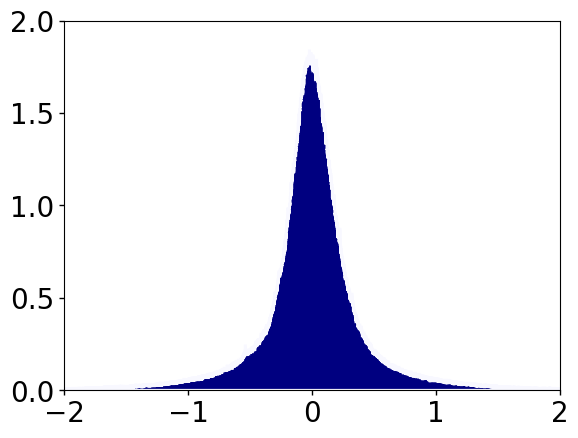

In [18]:
mobilenet_v2_feature1_mean = np.mean(mobilenet_v2_feature1)
mobilenet_v2_feature1_sigma = np.std(mobilenet_v2_feature1)
n, bins, patches = plt.hist(mobilenet_v2_feature1, bins=10000, density=True, alpha=1,
          histtype='stepfilled', facecolor = 'navy', edgecolor='ghostwhite', linewidth=2)


plt.ylim(0,2)
plt.xlim(-2,2)
mobilenet_v2_feature1_max = max(mobilenet_v2_feature1)
print(mobilenet_v2_feature1_max)
mobilenet_v2_feature1_min = min(mobilenet_v2_feature1)
print(mobilenet_v2_feature1_min)
# y = norm.pdf(bins,mobilenet_v2_feature1_mean,mobilenet_v2_feature1_sigma)
# plt.plot(bins,y,'k')

# plt.title("mobilenet_v2_feature1")
# plt.xlabel('Value')
# plt.ylabel('Normalized Frequency')
plt.tick_params(axis='both',labelsize=20,width=1,labelcolor="black")

plt.savefig('Mobilenet_v2_feature1.svg',dpi=1200,format='svg')

In [19]:
dymobilenet_v2_feature1 = torch.from_numpy(mobilenet_v2_feature1).float().to("cuda")
dymobilenet_v2_feature1 = dynbit(5,dymobilenet_v2_feature1)

After shape : torch.Size([3211264])


In [20]:
print(dymobilenet_v2_feature1.type)

<built-in method type of Tensor object at 0x7fdc1b251f90>


6.31781
-7.148602
tensor(6.)
tensor(-7.)


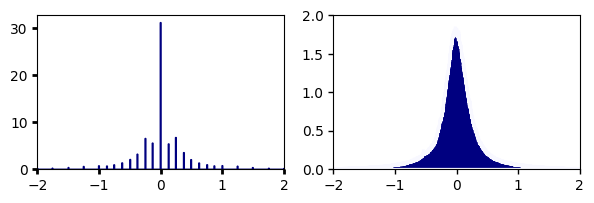

In [68]:
mobilenet_v2_feature1_mean = np.mean(mobilenet_v2_feature1)
mobilenet_v2_feature1_sigma = np.std(mobilenet_v2_feature1)

fig, subfig = plt.subplots(1,2,figsize=(7,2))
subfig[1].hist(mobilenet_v2_feature1, bins=10000, density=True, alpha=1,
          histtype='stepfilled', facecolor = 'navy', edgecolor='ghostwhite', linewidth=2)


subfig[1].set_ylim(0,2)
subfig[1].set_xlim(-2,2)
mobilenet_v2_feature1_max = max(mobilenet_v2_feature1)
print(mobilenet_v2_feature1_max)
mobilenet_v2_feature1_min = min(mobilenet_v2_feature1)
print(mobilenet_v2_feature1_min)

subfig[1].tick_params(axis='both',labelsize=10,width=1,labelcolor="black")


dymobilenet_v2_feature1 = dymobilenet_v2_feature1.to("cpu")


subfig[0].hist(dymobilenet_v2_feature1, bins=1000, density=True, alpha=1,
         histtype='step', facecolor = 'navy', edgecolor='navy', linewidth=1)

subfig[0].set_xlim(-2,2)
dymobilenet_v2_feature1_max = max(dymobilenet_v2_feature1)
print(dymobilenet_v2_feature1_max)
dymobilenet_v2_feature1_min = min(dymobilenet_v2_feature1)
print(dymobilenet_v2_feature1_min)

subfig[0].tick_params(axis='both',labelsize=10,width=2,labelcolor="black")

plt.savefig('Mobilenet_v2_feature1_5bit_subplot2.svg',dpi=1200,format='svg')

In [49]:
dyvit_large16_enlayer6 = torch.from_numpy(vit_large16_enlayer6).float().to("cuda")
dyvit_large16_enlayer6 = dynbit(8,dyvit_large16_enlayer6)

After shape : torch.Size([3227648])


135.06511
-23.138731
tensor(128.)
tensor(-23.)


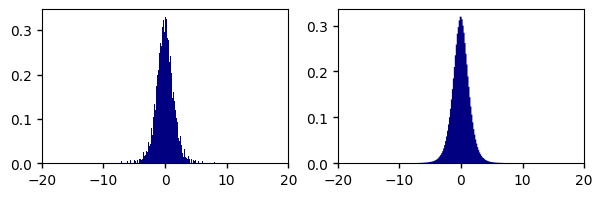

In [69]:
vit_large16_enlayer6_mean = np.mean(vit_large16_enlayer6)
vit_large16_enlayer6_sigma = np.std(vit_large16_enlayer6)

fig, subfig = plt.subplots(1,2,figsize=(7,2))

subfig[1].hist(vit_large16_enlayer6, bins=1000, density=True, alpha=1,
          histtype='stepfilled', facecolor = 'navy', edgecolor='navy', linewidth=0.001)

vit_max6 = max(vit_large16_enlayer6)
print(vit_max6)
vit_min6 = min(vit_large16_enlayer6)
print(vit_min6)

subfig[1].set_xlim(-20,20)




subfig[1].tick_params(axis='both',labelsize=10,width=1,labelcolor="black")

dyvit_large16_enlayer6 = dyvit_large16_enlayer6.to("cpu")
dyvit_large16_enlayer6_mean = torch.mean(dyvit_large16_enlayer6)
dyvit_large16_enlayer6_sigma = torch.std(dyvit_large16_enlayer6)

subfig[0].hist(dyvit_large16_enlayer6, bins=1000, density=True, alpha=1,
         histtype='barstacked', facecolor = 'navy', edgecolor='navy', linewidth=0.001)

# plt.ylim(0,0.1)
subfig[0].set_xlim(-20,20)
dyvit_large16_enlayer6_max = max(dyvit_large16_enlayer6)
print(dyvit_large16_enlayer6_max)
dyvit_large16_enlayer6_min = min(dyvit_large16_enlayer6)
print(dyvit_large16_enlayer6_min)



subfig[0].tick_params(axis='both',labelsize=10,width=1,labelcolor="black")
plt.savefig('Vit_8bit_subplot2.svg',dpi=1200,format='svg')

AttributeError: 'numpy.ndarray' object has no attribute 'hist'

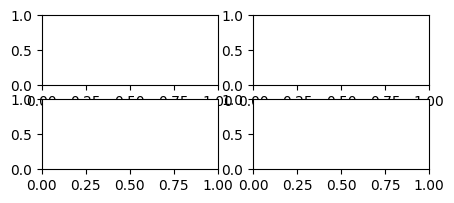

In [63]:
mobilenet_v2_feature1_mean = np.mean(mobilenet_v2_feature1)
mobilenet_v2_feature1_sigma = np.std(mobilenet_v2_feature1)

fig, subfig = plt.subplots(2,2,figsize=(5,2))
subfig[0].hist(mobilenet_v2_feature1, bins=10000, density=True, alpha=1,
          histtype='stepfilled', facecolor = 'navy', edgecolor='ghostwhite', linewidth=2)


subfig[0].set_ylim(0,2)
subfig[0].set_xlim(-2,2)
mobilenet_v2_feature1_max = max(mobilenet_v2_feature1)
print(mobilenet_v2_feature1_max)
mobilenet_v2_feature1_min = min(mobilenet_v2_feature1)
print(mobilenet_v2_feature1_min)

subfig[0].tick_params(axis='both',labelsize=20,width=1,labelcolor="black")


dymobilenet_v2_feature1 = dymobilenet_v2_feature1.to("cpu")


subfig[1].hist(dymobilenet_v2_feature1, bins=1000, density=True, alpha=1,
         histtype='step', facecolor = 'navy', edgecolor='navy', linewidth=1)

subfig[1].set_xlim(-2,2)
dymobilenet_v2_feature1_max = max(dymobilenet_v2_feature1)
print(dymobilenet_v2_feature1_max)
dymobilenet_v2_feature1_min = min(dymobilenet_v2_feature1)
print(dymobilenet_v2_feature1_min)

subfig[1].tick_params(axis='both',labelsize=20,width=1,labelcolor="black")


vit_large16_enlayer6_mean = np.mean(vit_large16_enlayer6)
vit_large16_enlayer6_sigma = np.std(vit_large16_enlayer6)

fig, subfig = plt.subplots(1,2,figsize=(10,3))

subfig[2].hist(vit_large16_enlayer6, bins=1000, density=True, alpha=1,
          histtype='stepfilled', facecolor = 'navy', edgecolor='navy', linewidth=0.001)

vit_max6 = max(vit_large16_enlayer6)
print(vit_max6)
vit_min6 = min(vit_large16_enlayer6)
print(vit_min6)

subfig[2].set_xlim(-20,20)




subfig[2].tick_params(axis='both',labelsize=20,width=1,labelcolor="black")

dyvit_large16_enlayer6 = dyvit_large16_enlayer6.to("cpu")
dyvit_large16_enlayer6_mean = torch.mean(dyvit_large16_enlayer6)
dyvit_large16_enlayer6_sigma = torch.std(dyvit_large16_enlayer6)

subfig[3].hist(dyvit_large16_enlayer6, bins=1000, density=True, alpha=1,
         histtype='barstacked', facecolor = 'navy', edgecolor='navy', linewidth=0.001)

# plt.ylim(0,0.1)
subfig[3].set_xlim(-20,20)
dyvit_large16_enlayer6_max = max(dyvit_large16_enlayer6)
print(dyvit_large16_enlayer6_max)
dyvit_large16_enlayer6_min = min(dyvit_large16_enlayer6)
print(dyvit_large16_enlayer6_min)



subfig[3].tick_params(axis='both',labelsize=20,width=1,labelcolor="black")


In [12]:
dymobilenet_v2_feature18 = torch.from_numpy(mobilenet_v2_feature18).float().to("cuda")
dymobilenet_v2_feature18 = dynbit(8,dymobilenet_v2_feature18)

After shape : torch.Size([250880])


In [ ]:
mobilenet_v2_feature1_mean = np.mean(mobilenet_v2_feature1)
mobilenet_v2_feature1_sigma = np.std(mobilenet_v2_feature1)
n, bins, patches = plt.hist(mobilenet_v2_feature1, bins=10000, density=True, alpha=1,
          histtype='stepfilled', facecolor = 'navy', edgecolor='ghostwhite', linewidth=2)


plt.ylim(0,2)
plt.xlim(-2,2)
mobilenet_v2_feature1_max = max(mobilenet_v2_feature1)
print(mobilenet_v2_feature1_max)
mobilenet_v2_feature1_min = min(mobilenet_v2_feature1)
print(mobilenet_v2_feature1_min)
# y = norm.pdf(bins,mobilenet_v2_feature1_mean,mobilenet_v2_feature1_sigma)
# plt.plot(bins,y,'k')

# plt.title("mobilenet_v2_feature1")
# plt.xlabel('Value')
# plt.ylabel('Normalized Frequency')
plt.tick_params(axis='both',labelsize=20,width=1,labelcolor="black")

plt.savefig('Mobilenet_v2_feature1.svg',dpi=1200,format='svg')

Text(0, 0.5, 'Normalized Frequency')

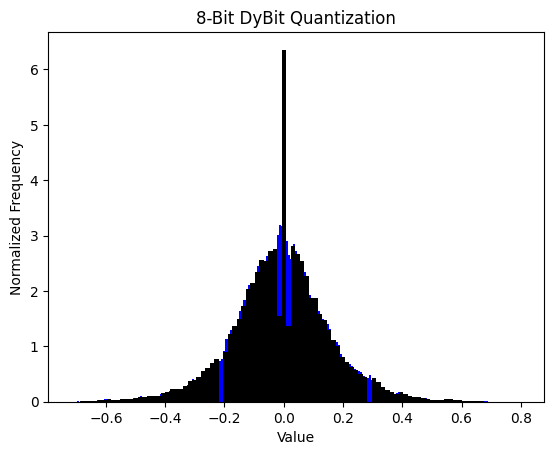

In [33]:
dymobilenet_v2_feature18 = dymobilenet_v2_feature18.to("cpu")
plt.hist(mobilenet_v2_feature18, bins=200, density=True, alpha=1,
         histtype='stepfilled', color='blue',
         edgecolor='none')
plt.hist(dymobilenet_v2_feature18, bins=200, density=True, alpha=1,
         histtype='barstacked',  facecolor = 'black', edgecolor='#169acf', linewidth=0.5)
plt.title("8-Bit DyBit Quantization")
plt.xlabel('Value')
plt.ylabel('Normalized Frequency')

Text(0, 0.5, 'Normalized Frequency')

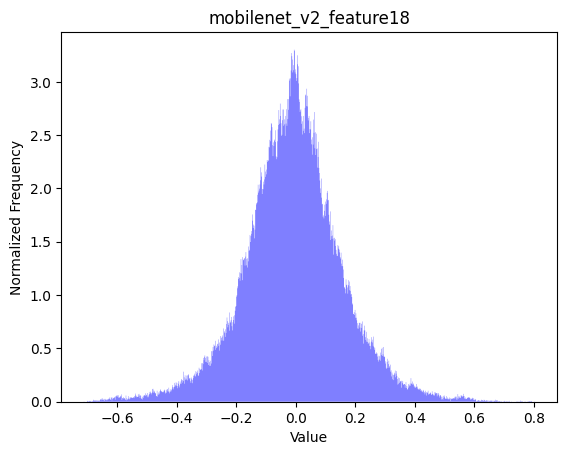

In [18]:
plt.hist(mobilenet_v2_feature18, bins=1000, density=True, alpha=0.5,
         histtype='stepfilled', color='blue',
         edgecolor='none');
plt.title("mobilenet_v2_feature18")
plt.xlabel('Value')
plt.ylabel('Normalized Frequency')

Text(0, 0.5, 'Normalized Frequency')

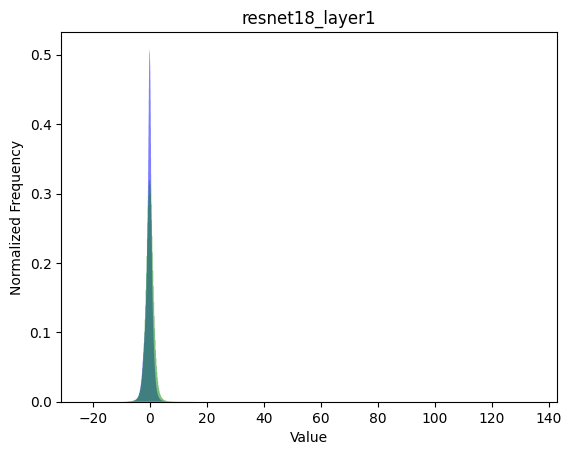

In [119]:
plt.hist(resnet18_layer1, bins=1000, density=True, alpha=0.5,
         histtype='stepfilled', color='blue',
         edgecolor='none');
plt.hist(vit_large16_enlayer6, bins=1000, density=True, alpha=0.5,
         histtype='stepfilled', color='green',
         edgecolor='none');
plt.title("resnet18_layer1")
plt.xlabel('Value')
plt.ylabel('Normalized Frequency')

In [123]:
vit_max = max(vit_large16_enlayer6)
print(vit_max)
vit_min = min(vit_large16_enlayer6)
print(vit_min)

135.06511
-23.138731


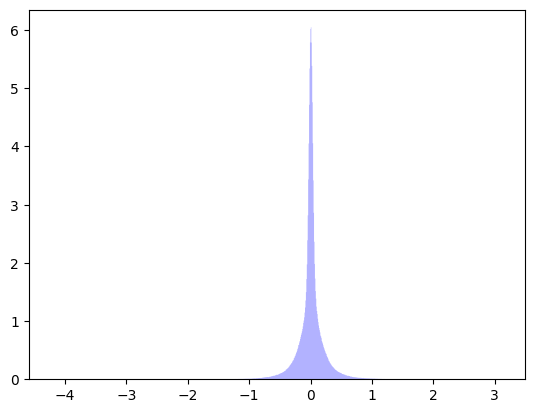

In [122]:
plt.hist(vit_base16_enlayer1, bins=1000, density=True, alpha=0.3,
         histtype='stepfilled', color='blue',
         edgecolor='none');
# plt.hist(vit_base16_enlayer6_ln, range=(-1,1), bins=1000, density=True, alpha=0.5,
#          histtype='stepfilled', color='green',
#          edgecolor='none');
